In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import time

In [3]:
sns.set(rc={'figure.figsize':(10,6)})

In [4]:
test = pd.read_csv("test.csv/test.csv")
train = pd.read_csv("sales_train.csv/sales_train_v2.csv")
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
cats = pd.read_csv('item_categories.csv')

In [5]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
cats.duplicated("item_category_name").nunique()

1

In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [9]:
shops.duplicated("shop_name").nunique()

1

In [10]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
items.duplicated("item_name").nunique()

1

In [12]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [13]:
test.shape

(214200, 3)

In [14]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


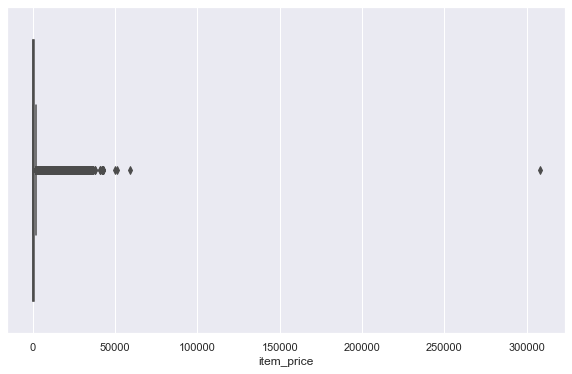

In [15]:
sns.boxplot(train.item_price)

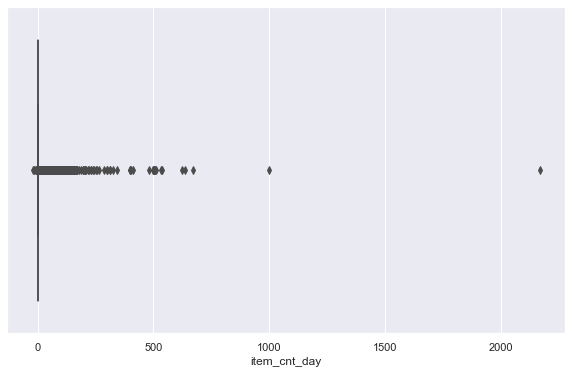

In [16]:
sns.boxplot(train.item_cnt_day)

In [17]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [18]:
train[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [19]:
train.loc[train.index == 484683, "item_price"] = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)].item_price.median()

In [20]:
train[train.index == 484683]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,1249.0,1.0


In [21]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [23]:
cats['split'] = cats["item_category_name"].str.split(" - ")
cats['type'] = cats['split'].apply(lambda x: x[0].strip())
cats['subtype'] = cats['split'].apply(lambda x: x[1].strip()  if len(x) > 1 else x[0].strip())
cats["type_code"] = le.fit_transform(cats.type)
cats["subtype_code"] = le.fit_transform(cats.subtype)
cats.head()

,item_category_name,item_category_id,split,type,subtype,type_code,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC, Гарнитуры/Наушники]",PC,Гарнитуры/Наушники,0,31
1,Аксессуары - PS2,1,"[Аксессуары, PS2]",Аксессуары,PS2,1,11
2,Аксессуары - PS3,2,"[Аксессуары, PS3]",Аксессуары,PS3,1,12
3,Аксессуары - PS4,3,"[Аксессуары, PS4]",Аксессуары,PS4,1,13
4,Аксессуары - PSP,4,"[Аксессуары, PSP]",Аксессуары,PSP,1,15


In [24]:
shops["split"] = shops.shop_name.str.split(" ", 1)
shops["city"] = shops.split.apply(lambda x: x[0])
shops["city_code"] = le.fit_transform(shops.city)
shops.head()

,shop_name,shop_id,split,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,"[!Якутск, Орджоникидзе, 56 фран]",!Якутск,0
1,"!Якутск ТЦ ""Центральный"" фран",1,"[!Якутск, ТЦ ""Центральный"" фран]",!Якутск,0
2,"Адыгея ТЦ ""Мега""",2,"[Адыгея, ТЦ ""Мега""]",Адыгея,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,"[Балашиха, ТРК ""Октябрь-Киномир""]",Балашиха,2
4,"Волжский ТЦ ""Волга Молл""",4,"[Волжский, ТЦ ""Волга Молл""]",Волжский,3


In [25]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [26]:
train["revenue"] = train["item_price"]*train["item_cnt_day"]
train =  pd.merge(left=train, right=items, how="left", on="item_id")
del train["item_name"]
train =  pd.merge(left=train, right=cats, how="left", on="item_category_id")
del train["item_category_name"]
del train["split"]
del train["type"]
del train["subtype"]
train =  pd.merge(left=train, right=shops, how="left", on="shop_id")
del train["city"]
del train["split"]
del train["shop_name"]

In [27]:
train2 = pd.merge(left=train, right=test, how="inner", sort=False)

In [28]:
len(list(train2[train2["shop_id"].isnull()].ID))

0

In [29]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,item_category_id,type_code,subtype_code,city_code
0,02.01.2013,0,59,22154,999.00,1.0,999.00,37,11,1,31
1,03.01.2013,0,25,2552,899.00,1.0,899.00,58,13,29,14
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00,58,13,29,14
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05,58,13,29,14
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00,56,13,5,14


Теперь сгруппируем продажи по паре магазин-товар для подсчета общего количества продаж за период, которое будет выступать искомой величиной в нашей модели

In [30]:
train["merged_params"] = train.shop_id.astype(str) + '_' + train.item_id.astype(str)
train["shop_item_id"] = train.merged_params.astype('category').cat.codes
del train["merged_params"]

In [31]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,item_category_id,type_code,subtype_code,city_code,shop_item_id
0,02.01.2013,0,59,22154,999.00,1.0,999.00,37,11,1,31,385713
1,03.01.2013,0,25,2552,899.00,1.0,899.00,58,13,29,14,107235
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00,58,13,29,14,107235
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05,58,13,29,14,107237
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00,56,13,5,14,107238


Здесь можно поэкспериментировать с другой мерой центральной тенденции для определения цены

In [32]:
get_first = lambda s: s.iloc[0]

In [54]:
%%time
train_grouped = train.groupby(["date_block_num", "shop_item_id"], as_index=False).aggregate({"item_cnt_day": "sum", "item_price": "mean", "item_category_id": get_first, "type_code": get_first, "subtype_code": get_first,"city_code": get_first, "shop_id": get_first})

Wall time: 1min 27s


In [56]:
train_grouped = train_grouped.drop("shop_item_id", axis=1)

In [57]:
train_grouped.head()

,date_block_num,item_cnt_day,item_price,item_category_id,type_code,subtype_code,city_code,shop_id
0,0,2.0,110.0,55,13,4,7,11
1,0,1.0,58.0,67,14,54,7,11
2,0,1.0,473.0,38,11,2,7,11
3,0,1.0,242.0,40,11,6,7,11
4,0,1.0,72.0,40,11,6,7,11


Добавим отдельной переменной номер месяца для учета цикличности

In [58]:
train_grouped["month"] = train_grouped["date_block_num"] % 12 + 1

In [61]:
train_grouped["item_category_id"].astype("category", copy=False)
train_grouped["type_code"].astype("category", copy=False)
train_grouped["subtype_code"].astype("category", copy=False)
train_grouped["city_code"].astype("category", copy=False)
train_grouped["month"].astype("category", copy=False)
"done"

'done'

In [62]:
train_grouped.head()

,date_block_num,item_cnt_day,item_price,item_category_id,type_code,subtype_code,city_code,shop_id,month
0,0,2.0,110.0,55,13,4,7,11,1
1,0,1.0,58.0,67,14,54,7,11,1
2,0,1.0,473.0,38,11,2,7,11,1
3,0,1.0,242.0,40,11,6,7,11,1
4,0,1.0,72.0,40,11,6,7,11,1


Разобьем датафрейм для того, чтобы хватило памяти

In [63]:
train_grouped.shape

(1609123, 9)

In [64]:
train_grouped.nunique()

date_block_num         34
item_cnt_day          445
item_price          41463
item_category_id       84
type_code              20
subtype_code           67
city_code              31
shop_id                57
month                  12
dtype: int64

In [65]:
data = pd.get_dummies(train_grouped, columns=["item_category_id", "type_code", "subtype_code", "city_code", "month", "shop_id"]).astype(np.int8)

In [69]:
data.shape

(1609123, 274)

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [71]:
X = data.drop(["item_cnt_day"], axis=1)
y = data.item_cnt_day

X_train, X_test = train_test_split(X, test_size=0.2)
y_train, y_test = train_test_split(y, test_size=0.2)

In [72]:
from sklearn.linear_model import LinearRegression

In [78]:
%%time
reg = LinearRegression(normalize=False).fit(X_train, y_train)
reg.score(X_train, y_train)

Wall time: 23.8 s


0.00013392783336785286

Модели не хватает сложности, потому необходимо попробовать либо регрессию большей степени, либо нейронную сеть либо randomforestregressor